In [1]:
import os
path = os.path.abspath(os.getcwd())

In [30]:
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
import csv

from nistrng import pack_sequence, check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY
from nistrng.sp800_22r1a import MonobitTest, FrequencyWithinBlockTest, RunsTest, LongestRunOnesInABlockTest, \
    DiscreteFourierTransformTest, NonOverlappingTemplateMatchingTest, SerialTest, ApproximateEntropyTest, \
    CumulativeSumsTest, RandomExcursionTest, RandomExcursionVariantTest

In [3]:
# Parameters
bitsize: np.int64 = 32
mask: np.int64 = (1<<bitsize)-1
mask

4294967295

In [4]:
def printif(verbose, string):
    if verbose:
        print(string)

In [5]:
def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        
def append_to_csv(filename, data):
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

# I/ Operational functions
## 1) Binary operations

In [5]:
def xor(a, b): 
    return (a^b) & mask

assert( xor(0b10, 0b100) == 0b110)

In [6]:
def add(a, b): 
    return (a + b) & mask

assert( add(0b10, 0b101) == 0b111 )

In [7]:
def bitrol(n, r):
    return ((n << r) & mask) | ((n >> (bitsize - r)) & mask)

In [8]:
a = 0b111111111111111111111111111111111  # A 33-bit number
b = 0b101010101010101010101010101010101  # Another 33-bit number

bin(xor(a, b))

'0b10101010101010101010101010101010'

In [9]:
def binprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += bin(i) + ", "
    s += bin(pool[-1]) + "]"
    print(s)

In [10]:
def strprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += str(i) + ", "
    s += str(pool[-1]) + "]"
    print(s)

## 2) Entropy gathering functions

In [11]:
def hsiphash_perm(pool):
    assert(bitsize==32)
    rol32 = bitrol
    
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
    
    a = add(a, b)
    b = rol32(b, 5)
    b = xor(b, a)
    a = rol32(a, 16)
    
    c = add(c, d)
    d = rol32(d, 8)
    d = xor(d, c)
    
    a = add(a, d)
    d = rol32(d, 7)
    d = xor(d, a)
    
    c = add(c, b)
    b = rol32(b, 13)
    b = xor(b, c)
    c = rol32(c, 16)
    
    return [a, b, c, d]

In [12]:
def siphash_perm(pool):
    assert(bitsize==64)
    rol64 = bitrol
    
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
    
    a = add(a, b)
    b = rol64(b, 13)
    b = xor(b, a)
    a = rol64(a, 32)
    
    c = add(c, d)
    d = rol64(d, 16)
    d = xor(d, c)
    
    a = add(a, d)
    d = rol64(d, 21)
    d = xor(d, a)
    
    c = add(c, b)
    b = rol64(b, 17)
    b = xor(b, c)
    c = rol64(c, 32)
    
    return [a, b, c, d]

In [13]:
if bitsize == 32: 
    fastmix_perm = hsiphash_perm
else: 
    fastmix_perm = siphash_perm

In [14]:
def fast_mix(pool, input1, input2):
    pool[3] = xor(pool[3], input1)
    pool = fastmix_perm(pool)
    pool[0] = xor(pool[0], input1)
    
    pool[3] = xor(pool[3], input2)
    pool = fastmix_perm(pool)
    pool[0] = xor(pool[0], input2)
    
    return pool

In [15]:
def rot_mix(pool, input1, input2, r): 
    pool = xor(pool, input1)
    pool = xor(pool, input2)
    pool = bitrol(pool, r)
    
    return pool

## 3) Distributions
### A. Timestamp value

In [16]:
def generate_cauchy(gamma, x0, size):
    cauchy_array = np.random.standard_cauchy(size) * gamma + x0
    return cauchy_array.astype(int)

bins  = 2000
range = (-262144, 262144)


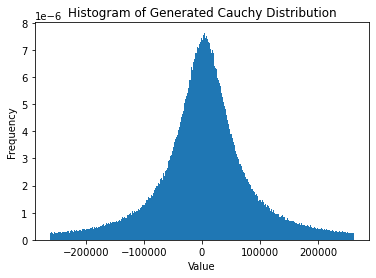

In [17]:
gamma, x0, size = 48031, 3818, 4000000
theta_distrib = generate_cauchy(gamma, x0, size)

bins = int(np.sqrt(size))
a = 2**18
plot_range = (-a,a)

print("bins  =", bins)
print("range =", plot_range)

plt.hist(theta_distrib, bins=bins, density=True, range=plot_range)
plt.title("Histogram of Generated Cauchy Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### B. Data value

In [18]:
data_value_distribution = [[0, 1]]

data_elements = [element for element, probability in data_value_distribution]
data_probabilities = [probability for element, probability in data_value_distribution]

In [19]:
def draw_data_value(N):
    drawn_element = rd.choices(data_elements, data_probabilities, k=N)
    return drawn_element

# II/ Simulation

In [20]:
chosen_tests: dict = {
    'monobit': MonobitTest(),
    'frequency_within_block': FrequencyWithinBlockTest(),
    'runs': RunsTest(),
    'longest_run_ones_in_a_block': LongestRunOnesInABlockTest(),
    'dft': DiscreteFourierTransformTest(),
#     'non_overlapping_template_matching': NonOverlappingTemplateMatchingTest(),
#     'serial': SerialTest(),
#     'approximate_entropy': ApproximateEntropyTest(),
    'cumulative sums': CumulativeSumsTest(),
#     'random_excursion': RandomExcursionTest(),
    'random_excursion_variant': RandomExcursionVariantTest()
}

## A. Siphash

In [21]:
def make_siphash_sim(gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ [0,0,0,0] for _ in range(N)]
    output = []
    
    delta_values = np.array([delay for _ in range(N)])
    timestamp_values = np.array([0 for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        delta_values_prev, timestamp_values_prev = delta_values, timestamp_values
        
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values_prev + theta_values
        timestamp_values = timestamp_values_prev + delta_values
            
        data_values = draw_data_value(N)
        
        for i in range(N): 
            pools[i] = fast_mix(pools[i], timestamp_values[i], data_values[i])
        
        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["siphash", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

            
    return output

In [22]:
make_siphash_sim(400, 0, 38229868, 8, 1000, chosen_tests, True)

Round0
	 - FAILED - score: 0.001 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.214 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.88 - Runs - elapsed time: 6 ms
	 - PASSED - score: 0.522 - Longest Run Ones In A Block - elapsed time: 6 ms
	 - PASSED - score: 0.151 - Discrete Fourier Transform - elapsed time: 1 ms
	 - FAILED - score: 0.002 - Cumulative Sums - elapsed time: 21 ms
	 - FAILED - score: 0.18 - Random Excursion Variant - elapsed time: 0 ms
Round1
	 - PASSED - score: 0.729 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.678 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.531 - Runs - elapsed time: 5 ms
	 - PASSED - score: 0.329 - Longest Run Ones In A Block - elapsed time: 6 ms
	 - PASSED - score: 0.72 - Discrete Fourier Transform - elapsed time: 1 ms
	 - PASSED - score: 0.782 - Cumulative Sums - elapsed time: 23 ms
	 - FAILED - score: 0.436 - Random Excursion Variant - elapsed time: 0 ms
Round2
	 - PASSED - score: 0.07 - Mon

[['siphash', 400, 0, 38229868, 0, 'Monobit', 0.0009350263526396278, False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Frequency Within Block',
  0.21422065088484799,
  True],
 ['siphash', 400, 0, 38229868, 0, 'Runs', 0.87977481520582, True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.5219954540454557,
  True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Discrete Fourier Transform',
  0.15089717233443065,
  True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Cumulative Sums',
  0.00159276194148672,
  False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Random Excursion Variant',
  0.18001544175375034,
  False],
 ['siphash', 400, 0, 38229868, 1, 'Monobit', 0.7288989565039765, True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  0.6780479924866614,
  True],
 ['siphash', 400, 0, 38229868, 1, 'Runs', 0.5308081062288923, True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.32867770619449876,
  

In [23]:
make_siphash_sim(48031, 3818, 38229868, 8, 1000, chosen_tests, True)

Round0
	 - PASSED - score: 0.32 - Monobit - elapsed time: 1 ms
	 - PASSED - score: 0.491 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.431 - Runs - elapsed time: 5 ms
	 - PASSED - score: 0.126 - Longest Run Ones In A Block - elapsed time: 6 ms
	 - PASSED - score: 0.473 - Discrete Fourier Transform - elapsed time: 1 ms
	 - PASSED - score: 0.281 - Cumulative Sums - elapsed time: 24 ms
	 - PASSED - score: 0.637 - Random Excursion Variant - elapsed time: 0 ms
Round1
	 - PASSED - score: 0.814 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.119 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.223 - Runs - elapsed time: 5 ms
	 - PASSED - score: 0.926 - Longest Run Ones In A Block - elapsed time: 6 ms
	 - PASSED - score: 0.798 - Discrete Fourier Transform - elapsed time: 1 ms
	 - PASSED - score: 0.672 - Cumulative Sums - elapsed time: 23 ms
	 - PASSED - score: 0.61 - Random Excursion Variant - elapsed time: 0 ms
Round2
	 - PASSED - score: 0.042 - M

[['siphash', 48031, 3818, 38229868, 0, 'Monobit', 0.3197118253210002, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Frequency Within Block',
  0.4907516851380816,
  True],
 ['siphash', 48031, 3818, 38229868, 0, 'Runs', 0.4305250161315532, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.12562552982838796,
  True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Discrete Fourier Transform',
  0.4726433201712496,
  True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Cumulative Sums',
  0.28057751444977286,
  True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion Variant',
  0.6366788070969138,
  True],
 ['siphash', 48031, 3818, 38229868, 1, 'Monobit', 0.8143739514039188, True],
 ['siphash',
  48031,
  3818,
  38229868,
  1,
  'Frequency Within Block',
  0.118556886773451,
  True],
 ['siphash', 48031, 3818, 38229868, 1, 'Runs', 0.22285660181148897, True],
 ['siphash',
  48031,
  3818,
  38229868,
  1,
  'Longes

## B. Rotations

In [83]:
def make_rotation_sim(rot, gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ 0 for _ in range(4*N)]
    output = []
    
    delta_values = np.array([delay for _ in range(N)])
    timestamp_values = np.array([0 for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        delta_values_prev, timestamp_values_prev = delta_values, timestamp_values
        
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values_prev + theta_values
        timestamp_values = timestamp_values_prev + delta_values
            
        data_values = draw_data_value(N)
        
        for i in range(N): 
            pools[i] = rot_mix(pools[i], timestamp_values[i], data_values[i], rot)
        
        binary_sequence = pack_sequence(pools)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["rot"+str(rot), gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [87]:
make_rotation_sim(18, 400, 0, 38229868, 8, 1000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 11 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Cumulative Sums - elapsed time: 16 ms
	 - FAILED - score: 0.224 - Random Excursion Variant - elapsed time: 0 ms
Round1
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 18 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Cumulative Sums - elapsed time: 18 ms
	 - FAILED - score: 0.19 - Random Excursion Variant - elapsed time: 0 ms
Round2
	 - FAILED - score: 0.0 - Monobit - elapsed time: 

[['rot18', 400, 0, 38229868, 0, 'Monobit', 0.0, False],
 ['rot18', 400, 0, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['rot18', 400, 0, 38229868, 0, 'Runs', 0.0, False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  4.434855538103036e-30,
  False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Discrete Fourier Transform',
  1.3747269653078125e-303,
  False],
 ['rot18', 400, 0, 38229868, 0, 'Cumulative Sums', 0.0, False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Random Excursion Variant',
  0.22403148498942502,
  False],
 ['rot18', 400, 0, 38229868, 1, 'Monobit', 0.0, False],
 ['rot18', 400, 0, 38229868, 1, 'Frequency Within Block', 0.0, False],
 ['rot18', 400, 0, 38229868, 1, 'Runs', 0.0, False],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  8.238522856058244e-09,
  False],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Discrete Fourier Transform',
  5.090697e-317,
  False],
 ['rot18', 400, 0, 38229868, 1, 'Cumulative Sums'

In [88]:
make_rotation_sim(18, 48031, 3818, 38229868, 8, 1000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 4 ms
	 - FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Cumulative Sums - elapsed time: 26 ms
	 - PASSED - score: 0.417 - Random Excursion Variant - elapsed time: 0 ms
Round1
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 0 ms
	 - PASSED - score: 0.185 - Longest Run Ones In A Block - elapsed time: 17 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Cumulative Sums - elapsed time: 18 ms
	 - PASSED - score: 0.31 - Random Excursion Variant - elapsed time: 1 ms
Round2
	 - FAILED - score: 0.0 - Monobit - elapsed time:

[['rot18', 48031, 3818, 38229868, 0, 'Monobit', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 0, 'Runs', 0.0, False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  2.6648883100495264e-14,
  False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Discrete Fourier Transform',
  1.43165e-319,
  False],
 ['rot18', 48031, 3818, 38229868, 0, 'Cumulative Sums', 0.0, False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion Variant',
  0.4172240740652191,
  True],
 ['rot18', 48031, 3818, 38229868, 1, 'Monobit', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 1, 'Frequency Within Block', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 1, 'Runs', 0.0, False],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.1847475346148108,
  True],
 ['rot18', 48031, 3818, 38229868, 1, 'Discrete Fourier Transform', 0.0, False],
 ['rot18', 48031, 3818, 38229

## C. Averaged result

In [20]:
def init_csv():
    write_to_csv('out\\output.csv', [['function','gamma','x0','delay','round','test','score','passed']])

In [22]:
def run_simulation(gamma, x0, delay, rounds, N, repeats):
    
    for r in range(repeats):
        print("Repeat "+str(r))
        output = make_siphash_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv('out\\output.csv', output)
        print('\tSiphash done.')

        for rot in range(bitsize - 1):
            output = make_rotation_sim(rot+1, gamma, x0, delay, rounds, N, chosen_tests, False) 
            append_to_csv('out\\output.csv', output)
            print('\tRot ' + str(rot+1) + " done.")

In [23]:
data_value_distribution = [
    [4112549988, 0.729635], [3995109476, 0.177747], [3709896804, 0.072718],
    [4005702796, 0.010259], [3995352108, 0.004920], [4005727176, 0.000448],
    [4246767716, 0.000396], [4123167688, 0.000297], [4112865224, 0.000261],
    [3995247160, 0.000223], [3995185056, 0.000115], [4112960576, 0.000110],
    [4112786712, 0.000072], [4113351664, 0.000070], [4123167300, 0.000070],
    [3720514504, 0.000058], [3710212040, 0.000053], [3712703804, 0.000050],
    [3995424712, 0.000050], [4113352520, 0.000048]
]

data_elements = [element for element, probability in data_value_distribution]
data_probabilities = [probability for element, probability in data_value_distribution]

init_csv()
run_simulation(48031, 3818, 38229868, 8, 500000, 3)
run_simulation(48125, 3804, 38229868, 8, 500000, 3)
run_simulation(444592, -2986, 572059897, 8, 500000, 3)
run_simulation(47339, 7476, 38228910, 8, 500000, 3)
run_simulation(73323, 5263, 38228910, 8, 500000, 3)

Repeat 0


NameError: name 'make_siphash_sim' is not defined

# III/ Result analysis

In [15]:
def import_csv(filename): 
    data_path = path + "\\" + filename + ".csv"
    data = pd.read_csv(data_path)
        
    return data

In [16]:
filename = 'out\\output'
data = import_csv(filename)
data

,function,gamma,x0,delay,round,test,score,passed
0,siphash,48031,3818,38229868,0,Monobit,2.328446e-07,False
1,siphash,48031,3818,38229868,0,Frequency Within Block,1.204606e-03,False
2,siphash,48031,3818,38229868,0,Runs,3.220997e-03,False
3,siphash,48031,3818,38229868,0,Longest Run Ones In A Block,3.118483e-01,True
4,siphash,48031,3818,38229868,0,Discrete Fourier Transform,7.707775e-01,True
...,...,...,...,...,...,...,...,...
3110,rot24,48031,3818,38229868,4,Runs,0.000000e+00,False
3111,rot24,48031,3818,38229868,4,Longest Run Ones In A Block,1.976931e-01,True
3112,rot24,48031,3818,38229868,4,Discrete Fourier Transform,0.000000e+00,False
3113,rot24,48031,3818,38229868,4,Cumulative Sums,0.000000e+00,False


## A. Data processing

In [17]:
data_average = data.groupby(['function', 'gamma', 'x0', 'delay', 'round'])['score'].mean().reset_index()
data_average

,function,gamma,x0,delay,round,score
0,rot1,48031,3818,38229868,0,0.046710
1,rot1,48031,3818,38229868,1,0.045076
2,rot1,48031,3818,38229868,2,0.062514
3,rot1,48031,3818,38229868,3,0.053253
4,rot1,48031,3818,38229868,4,0.105860
...,...,...,...,...,...,...
155,siphash,48031,3818,38229868,0,0.205138
156,siphash,48031,3818,38229868,1,0.400492
157,siphash,48031,3818,38229868,2,0.632286
158,siphash,48031,3818,38229868,3,0.545340


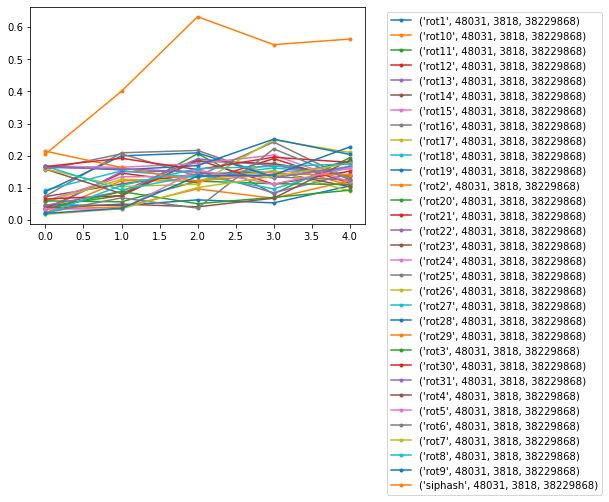

In [18]:
data_grouped = data_average.groupby(['function', 'gamma', 'x0', 'delay'])

fig, ax = plt.subplots()

for name, group in data_grouped:
    ax.plot(group['round'], group['score'], marker='o', linestyle='-', ms=3, label=name)

# Maybe add a legend outside of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [10]:
test = data_average[data_average['round'] == 1]
test.sort_values('score')

,function,gamma,x0,delay,round,score
131,rot5,48031,3818,38229868,1,0.033165
141,rot7,48031,3818,38229868,1,0.035009
151,rot9,48031,3818,38229868,1,0.036325
56,rot2,48031,3818,38229868,1,0.040038
1,rot1,48031,3818,38229868,1,0.045076
126,rot4,48031,3818,38229868,1,0.049371
61,rot20,48031,3818,38229868,1,0.056511
136,rot6,48031,3818,38229868,1,0.068809
66,rot21,48031,3818,38229868,1,0.075295
11,rot11,48031,3818,38229868,1,0.075868
